# Tutorial Notebook to Finetune TensorFlow based SegFormer model 

The tutorial shows how to fine-tune a SegFormer model in TensorFlow for the task of semantic segmentation. The tutorial is a TensorFlow port of this [blog post](https://huggingface.co/blog/fine-tune-segformer). As such, the notebook uses code from the blog post.

## Install Necessary Packages

In [ ]:
!pip -q install datasets==2.3.2
!pip -q install huggingface-hub==0.8.1

     |████████████████████████████████| 362 kB 5.3 MB/s 
     |████████████████████████████████| 140 kB 66.1 MB/s 
     |████████████████████████████████| 212 kB 69.7 MB/s 
     |████████████████████████████████| 1.1 MB 63.1 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
     |████████████████████████████████| 596 kB 58.2 MB/s 
     |████████████████████████████████| 127 kB 73.7 MB/s 
     |████████████████████████████████| 271 kB 75.8 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 144 kB 52.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install git+https://github.com/huggingface/transformers -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 5.2 MB/s 


In [ ]:
# Ensure we have access to a GPU.
!nvidia-smi

Thu Jul 14 03:20:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Modules and Setup Hyperparameters

In [ ]:
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datasets import load_dataset, load_metric
from huggingface_hub import cached_download, hf_hub_url
from tensorflow.keras.optimizers import Adam

from transformers import (
    DefaultDataCollator,
    SegformerFeatureExtractor,
    TFSegformerForSemanticSegmentation,
    create_optimizer,
)
from transformers.keras_callbacks import KerasMetricCallback

In [ ]:
epochs = 2
lr = 0.00006
batch_size = 2

For the purpose of this example, we will keep the runtime short (2 epochs only). But we will provide a link to a model checkpoint that was trained for 50 epochs with the exact same code.

## Build Data Pipeline

### Load prepared dataset

In [ ]:
hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

Using custom data configuration segments--sidewalk-semantic-2-22193ffec3fd88bf
Reusing dataset parquet (/root/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-22193ffec3fd88bf/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/1 [00:00<?, ?it/s]

### Split training dataset into train and test

In [ ]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
val_ds = ds["test"]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-22193ffec3fd88bf/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8/cache-867706e2b6fd7502.arrow


In [ ]:
# Preview an image.
train_ds[0]["pixel_values"]

### Setup id to label, label to id maps

In [ ]:
repo_id = f"datasets/{hf_dataset_identifier}"
filename = "id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename)), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


### Transform

To keep the example simple we drop the additional transformations used in [the original blog post](https://huggingface.co/blog/fine-tune-segformer). 

In [ ]:
feature_extractor = SegformerFeatureExtractor()


def transforms(image):
    image = tf.keras.utils.img_to_array(image)
    image = image.transpose((2, 0, 1))
    return image


def preprocess(example_batch):
    images = [transforms(x.convert("RGB")) for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs

In [ ]:
train_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)

Parameter 'transform'=<function preprocess at 0x7f989b538d40> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
# Preview the features of `train_ds`.
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 800
})

### Convert 🤗 Dataset into TensorFlow compatible dataset

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

val_set = val_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [ ]:
# Look at the shapes of each features within the dataset.
train_set.element_spec

{'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.int64, name=None),
 'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None)}

In [ ]:
# Investigate a single batch.
batch = next(iter(train_set))
batch["pixel_values"].shape, batch["labels"].shape

(TensorShape([2, 3, 512, 512]), TensorShape([2, 512, 512]))

## Build Model

### KerasMetricCallback from 🤗 Dataset to compute metrics 

In [ ]:
metric = load_metric("mean_iou")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits are of shape (batch_size, num_labels, height, width), so
    # we first transpose them to (batch_size, height, width, num_labels)
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])
    # scale the logits to the size of the label
    logits_resized = tf.image.resize(
        logits,
        size=tf.shape(labels)[1:],
        method="bilinear",
    )
    # compute the prediction labels and compute the metric
    pred_labels = tf.argmax(logits_resized, axis=-1)
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=num_labels,
        ignore_index=-1,
        reduce_labels=feature_extractor.reduce_labels,
    )
    return {"val_" + k: v for k, v in metrics.items()}


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_set,
    batch_size=batch_size,
    label_cols=["labels"],
)

### Build model

In [ ]:
model_checkpoint = "nvidia/mit-b0"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

optimizer = Adam(learning_rate=lr)
model.compile(optimizer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFSegformerForSemanticSegmentation were not initialized from the PyTorch model and are newly initialized: ['decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_hea

In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMainL  multiple                 3319392   
 ayer)                                                           
                                                                 
 decode_head (TFSegformerDec  multiple                 404259    
 odeHead)                                                        
                                                                 
Total params: 3,723,651
Trainable params: 3,723,139
Non-trainable params: 512
_________________________________________________________________


In [ ]:
# Dummy forward pass.
outputs = model(batch)
outputs.loss, outputs.logits.shape

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.530883], dtype=float32)>,
 TensorShape([2, 35, 128, 128]))

### Train the model

In [ ]:
callbacks = [metric_callback] 

In [ ]:
# To keep the runtime of this example short, we will train it for only two epochs.
# For real applications purposes, note that you will likely need a longer training schedule.

model.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
)

Epoch 1/2
400/400 [==============================] - ETA: 0s - loss: 1.3107

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


400/400 [==============================] - 541s 1s/step - loss: 1.3107 - val_loss: 1.0133 - val_mean_iou: 0.1859 - val_mean_accuracy: 0.2342 - val_overall_accuracy: 0.7387 - val_per_category_iou: nan - val_per_category_accuracy: nan
Epoch 2/2
400/400 [==============================] - 523s 1s/step - loss: 0.8141 - val_loss: 0.7729 - val_mean_iou: 0.2530 - val_mean_accuracy: 0.3105 - val_overall_accuracy: 0.7875 - val_per_category_iou: nan - val_per_category_accuracy: nan


## Evaluate the model

Now that we have seen how we can fine-tune the SegFormer model it's time to see how to evaluate it. For this purpose, we'll use a model that was trained for 50 epochs using the exact same code. 

In [ ]:
# First, let's load the model.
finetuned_model_ckpt = "sayakpaul/mit-b0-finetuned-sidewalk-semantic"
pretrained_model = TFSegformerForSemanticSegmentation.from_pretrained(
    finetuned_model_ckpt
)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at sayakpaul/mit-b0-finetuned-sidewalk-semantic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [ ]:
pretrained_model.compile()
eval_loss = pretrained_model.evaluate(val_set)
eval_loss

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


100/100 [==============================] - 42s 384ms/step - loss: 0.2739


0.2738516330718994

## Inference

In [ ]:
hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
inference = ds["test"]

Using custom data configuration segments--sidewalk-semantic-2-22193ffec3fd88bf
Reusing dataset parquet (/root/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-22193ffec3fd88bf/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-22193ffec3fd88bf/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8/cache-867706e2b6fd7502.arrow


In [ ]:
test_image = inference[0]["pixel_values"]
test_gt = inference[0]["label"]
test_image

In [ ]:
inputs = feature_extractor(images=test_image, return_tensors="tf")
print(inputs["pixel_values"].shape)

(1, 3, 512, 512)


In [ ]:
outputs = pretrained_model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# Transpose to have the shape (batch_size, height/4, width/4, num_labels)
logits = tf.transpose(logits, [0, 2, 3, 1])

# First, rescale logits to original image size
upsampled_logits = tf.image.resize(
    logits,
    test_image.size[
        ::-1
    ],  # We reverse the shape of `image` because `image.size` returns width and height.
)

# Second, apply argmax on the class dimension
pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]
print(pred_seg.shape)

(1080, 1920)


In [ ]:
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

In [ ]:
def get_seg_overlay(image, seg):
    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
    )  # height, width, 3
    palette = np.array(sidewalk_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

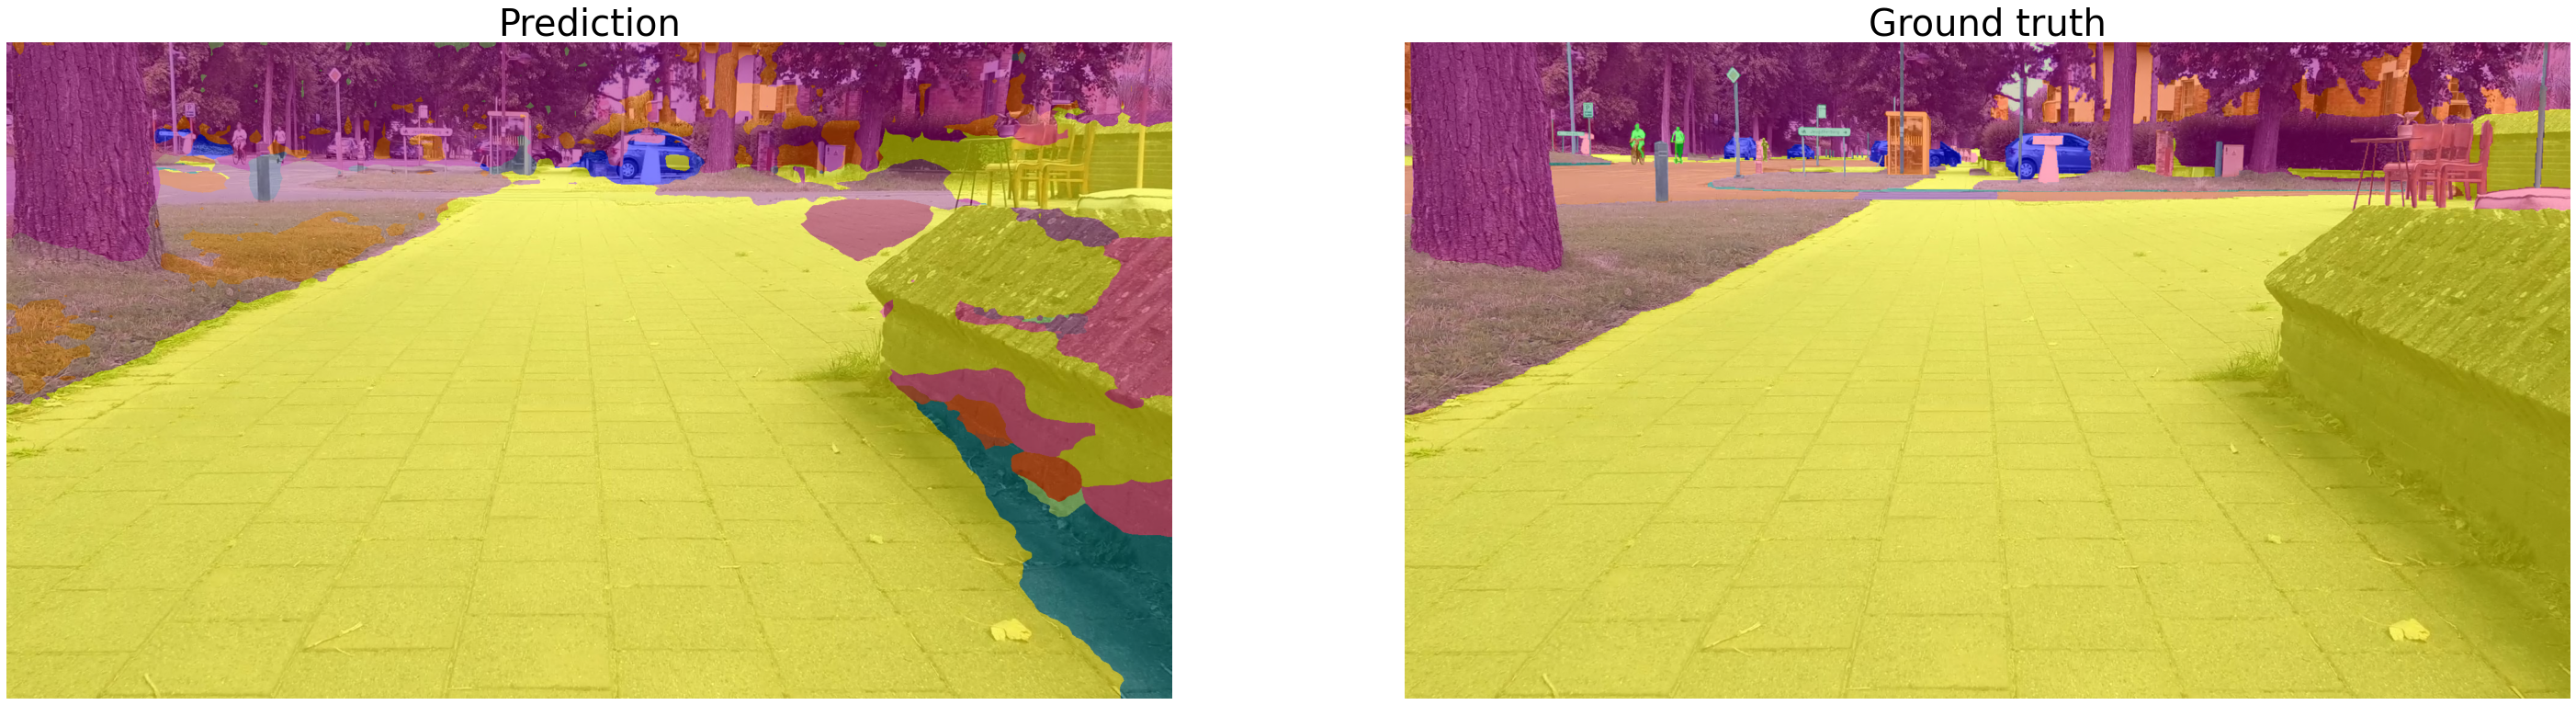

In [ ]:
pred_img = get_seg_overlay(test_image, pred_seg.numpy())
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {"fontsize": 40})
axs[0].imshow(pred_img)
axs[0].axis("off")
axs[1].set_title("Ground truth", {"fontsize": 40})
axs[1].imshow(gt_img)
axs[1].axis("off")

plt.show()

Our model is far from being perfect but it's getting there. Here are some ways to make it better:

* Our dataset is small and adding more samples to it will likely help the model.
* We didn't perform any hyperparameter tuning for the model. So, searching for better hyperparameters could be helpful. 
* Finally, using a larger model for fine-tuning could be beneficial.  